# FAD Project: Steam Games 2025 Dataset Analysis

# Introduction
## Abstract

This project analyzes a comprehensive dataset of Steam games released up to 2025, investigating three key questions about the gaming ecosystem. 
First, we examine the relationship between user review scores and professional critic ratings (Metacritic), revealing the correlation patterns between consumer and expert opinions. 
Second, we identify which game genres consistently achieve the highest review scores, helping understand player preferences across different gaming categories. 
Third, we determine which game developers produce titles with the most consistent quality ratings, providing insights into studio reliability. 
The analysis uses correlation techniques, descriptive statistics, and variability measures to extract meaningful patterns from the data. 
This exploration offers valuable insights into the dynamics between players, critics, and developers in the modern gaming industry.

Github Repository Link: __[Click Me](https://github.com/Darakuu/FAD_SteamGames_2025)__

## Questions answered:
1. What is the relationship between the review score and the Metacritic rating?
    (i.e., the correlation between user reviews and critics’ reviews)
2. Which genres achieve the highest review scores?
3. Which developers produce games with the most consistent review scores?

## Summary of used techniques: 
1. Correlation analysis (Pearson and Spearman) and linear regression. Extra visualization with box plots and violin plots due to the non-linear relationship. 
2. Descriptive statistics: mean, median, standard deviation, and variance: visualized with box plots.
3. Calculation of variability indices (standard deviation, range, and coefficient of variation) to measure score consistency for each developer; optionally, clustering to identify common patterns.

## Data acquisition
The __[Steam games Dataset 2025](https://www.kaggle.com/datasets/srgiomanhes/steam-games-dataset-2025)__ dataset was acquired via Kaggle. These kinds of datasets are usually created via web scraping techniques, as Valve allows for Steam to be accessed via its web-facing API.

# 1. Cleaning the data:

## 1.1 Helper functions

In [23]:
def print_filter_stats(in_df, step_name):
    """
    Print the number of rows in a DataFrame at each filtering step.

    Args:
        in_df: The pandas DataFrame to analyze
        step_name: A string describing the current filtering step

    Returns:
        The original DataFrame (to allow chaining)
    """
    print(f"Step: {step_name} - Rows remaining: {len(in_df):,} ({len(in_df)/initial_rows:.2%})")
    return in_df


In [24]:
def convert_date(date_str):
    try:
        # Try multiple date formats
        for fmt in ['%Y-%m-%d', '%b %d, %Y', '%B %d, %Y', '%Y']:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except:
                continue
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

## 1.2 Load and clean the dataset

In [25]:
import pandas as pd
from datetime import datetime

# Load the dataset
df = pd.read_csv('src/steam_games.csv')

# Inspect raw data format
print("Raw dataset overview:")
print(df.info(memory_usage="deep"))
print("\nSample of raw release_date values:")
print(df['release_date'].head(10))
print("\nUnique release_date formats:", df['release_date'].unique()[:10])

# Convert release_date to datetime, handling multiple formats
df['release_date'] = df['release_date'].apply(convert_date)

# Convert scores to numeric, printing unique values before conversion
print("\nUnique review_score values (sorted):", sorted([float(x) for x in df['review_score'].unique()]))
print("Unique metacritic values (sorted):", sorted([int(x) for x in df['metacritic'].unique()]))

df['review_score'] = pd.to_numeric(df['review_score'], errors='coerce')
df['metacritic'] = pd.to_numeric(df['metacritic'], errors='coerce')

# Filter data
today = pd.Timestamp(datetime.now())
initial_count = len(df)

# Start with the original dataframe
filtered_df = df.copy()
initial_rows = len(filtered_df)

# Step 1: Track the initial state
print_filter_stats(filtered_df, "1 - initial load")

# Step 2: Keep only released titles
filtered_df = filtered_df[filtered_df['is_released']]
print_filter_stats(filtered_df, "2 - released games filter")

# Step 3: Keep games with valid release dates before today
release_date_mask = filtered_df['release_date'].notna() & (filtered_df['release_date'] <= today)
filtered_df = filtered_df[release_date_mask]
print_filter_stats(filtered_df, "3 - release date filter")

# Step 4: Keep rows with valid scores (more permissive)
filtered_df = filtered_df.dropna(subset=['review_score', 'metacritic'], how='all')
print_filter_stats(filtered_df, "4 - score availability filter")

# Step 5: Keep games with at least one valid score > 0
score_mask = (filtered_df['review_score'] > 0) | (filtered_df['metacritic'] > 0)
filtered_df = filtered_df[score_mask]
print_filter_stats(filtered_df, "5 - positive score filter")

# Step 6: Remove duplicates
clean = filtered_df.drop_duplicates(subset='steam_appid')
print_filter_stats(clean, "6 - duplicate removal")


# Final dataset statistics
print("\nFinal cleaned dataset statistics:")
print("\nScore statistics:")
print(clean[['review_score', 'metacritic']].describe())

print("\nMissing values in final dataset:")
print(clean[['review_score', 'metacritic', 'release_date']].isna().sum())

# Save the cleaned dataset
clean.to_csv('src/steam_games_cleaned.csv', index=False)

# Display sample of the cleaned dataset
print("\nSample of cleaned dataset:")
print(clean.head())


Raw dataset overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71429 entries, 0 to 71428
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   steam_appid          71429 non-null  int64  
 1   name                 71429 non-null  object 
 2   developers           71429 non-null  object 
 3   publishers           71429 non-null  object 
 4   categories           71429 non-null  object 
 5   genres               71429 non-null  object 
 6   required_age         71429 non-null  int64  
 7   n_achievements       71429 non-null  int64  
 8   platforms            71429 non-null  object 
 9   is_released          71429 non-null  bool   
 10  release_date         71429 non-null  object 
 11  additional_content   71429 non-null  object 
 12  total_reviews        71429 non-null  int64  
 13  total_positive       71429 non-null  int64  
 14  total_negative       71429 non-null  int64  
 15  review_score  

## 1.3 Data Cleanup summary

During the data cleaning process, we encountered several challenges while preparing the Steam games dataset for analysis:

1. Initial Data Issues:
    - Raw dataset contained $71429$ games
    - Multiple date formats were present in the release_date column
    - Score columns had inconsistent numeric formats

2. Cleanup Steps:
    - Step 1: Loaded initial dataset ($71429$ rows)
    - Step 2: Filtered unreleased games
    - Step 3: Removed invalid release dates and future releases 
    - Step 4: Cleaned up missing review scores
    - Step 5: Removed games with zero/negative scores
    - Step 6: Eliminated duplicate entries based on the (unique) Steam app ID

3. Interesting Findings:
    - Multiple date formats required a flexible parser
    - Both user review scores and Metacritic ratings had some unusually low values
    - Several games appeared multiple times with different IDs
    - Some games had future release dates despite being marked as "released"

4. Data Quality Results:
    - Successfully standardized all dates to datetime format
    - Converted review scores to consistent numeric values
    - Removed duplicates and invalid entries
    - Final cleaned dataset represents a more accurate picture of released, reviewed games
    - Final Dataset entries reduced from $71429$ down to $24026$, about $33%$ of the original dataset.

This cleanup process ensures that our analysis works with valid, consistent data while maintaining transparency about what was excluded and why.

# 2. Data Analysis:

## 2.1 Relationship between review score and Metacritic rating

Number of games with both review score and Metacritic rating: 24026

Correlation Analysis:
Pearson correlation: 0.1164 (p-value: 3.21e-73)
Spearman correlation: 0.1249 (p-value: 4.54e-84)


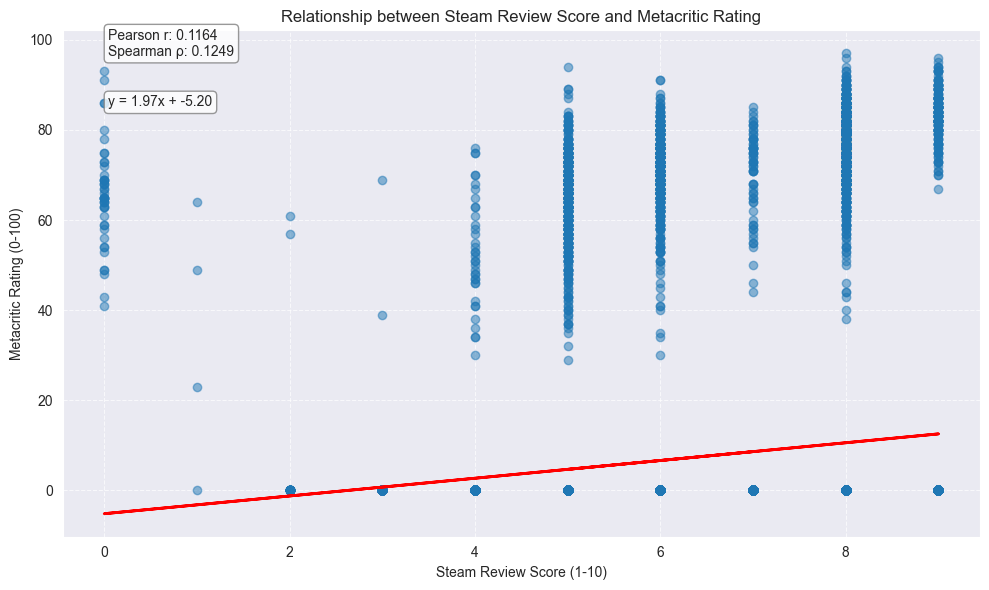


Linear Regression Results:
Slope (coefficient): 1.9689
Intercept: -5.1987
R² score: 0.0135


In [26]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

# Filter out rows where either review_score or metacritic is missing
score_df = clean.dropna(subset=['review_score', 'metacritic'])

# Print the number of games with both scores available
print(f"Number of games with both review score and Metacritic rating: {len(score_df)}")

# Calculate correlations
pearson_corr, pearson_p = stats.pearsonr(score_df['review_score'], score_df['metacritic'])
spearman_corr, spearman_p = stats.spearmanr(score_df['review_score'], score_df['metacritic'])

print(f"\nCorrelation Analysis:")
print(f"Pearson correlation: {pearson_corr:.4f} (p-value: {pearson_p:.2e})")
print(f"Spearman correlation: {spearman_corr:.4f} (p-value: {spearman_p:.2e})")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(score_df['review_score'], score_df['metacritic'], alpha=0.5)
plt.title('Relationship between Steam Review Score and Metacritic Rating')
plt.xlabel('Steam Review Score (1-10)')
plt.ylabel('Metacritic Rating (0-100)')
plt.grid(True, linestyle='--', alpha=0.7)

# Add linear regression line
X = score_df['review_score'].values.reshape(-1, 1)
y = score_df['metacritic'].values
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
plt.plot(score_df['review_score'], y_pred, color='red', linewidth=2)

# Add correlation information to the plot
plt.annotate(f"Pearson r: {pearson_corr:.4f}\nSpearman ρ: {spearman_corr:.4f}",
             xy=(0.05, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add regression equation
slope = model.coef_[0]
intercept = model.intercept_
plt.annotate(f"y = {slope:.2f}x + {intercept:.2f}",
             xy=(0.05, 0.85), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

# Print regression results
print(f"\nLinear Regression Results:")
print(f"Slope (coefficient): {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R² score: {model.score(X, y):.4f}")


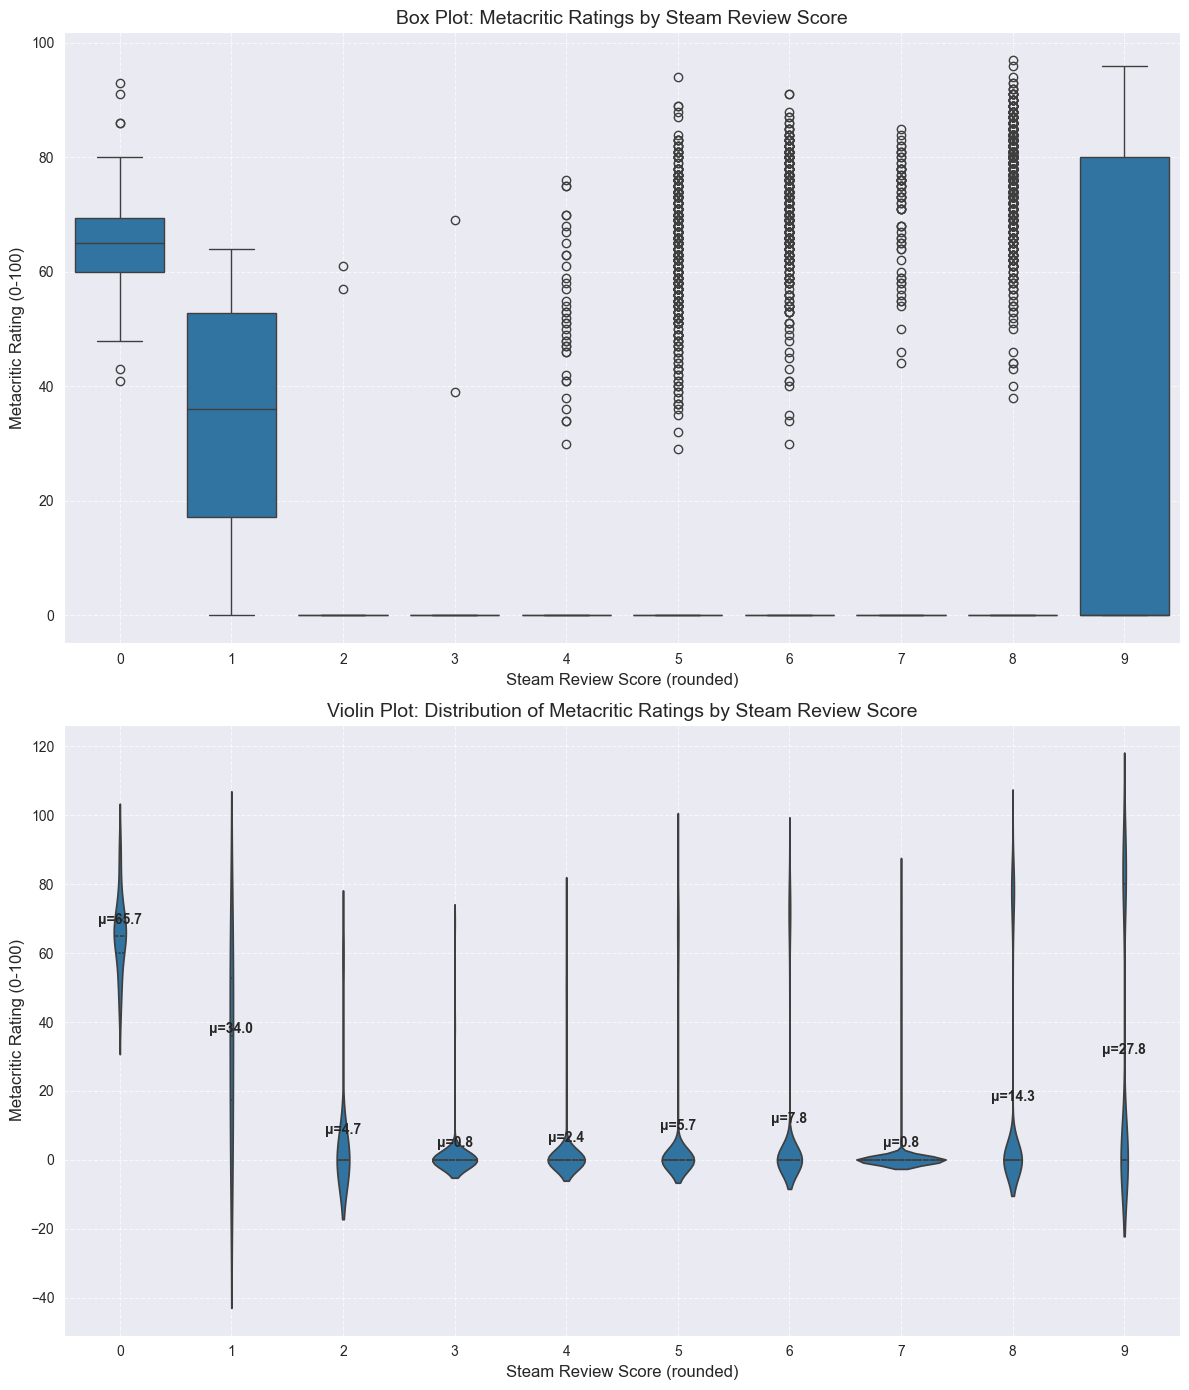


Summary Statistics by Review Score Group:
                      count       mean        std  min  median  max
review_score_rounded                                               
0                        47  65.680851  11.127925   41    65.0   93
1                         4  34.000000  28.296054    0    36.0   64
2                        25   4.720000  16.346559    0     0.0   61
3                       133   0.812030   6.850293    0     0.0   69
4                       806   2.447891  11.463651    0     0.0   76
5                      5730   5.744852  18.614803    0     0.0   94
6                      4224   7.750947  22.260699    0     0.0   91
7                      6076   0.766129   7.378968    0     0.0   85
8                      6399  14.307704  30.059910    0     0.0   97
9                       582  27.836770  39.524356    0     0.0   96


In [27]:
# Additional visualization using Box Plots and Violin Plots
import seaborn as sns

# Round review scores to the nearest integer for grouping
score_df['review_score_rounded'] = score_df['review_score'].round().astype(int)

# Create a figure with two subplots (box plot and violin plot)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))

# Box plot
sns.boxplot(x='review_score_rounded', y='metacritic', data=score_df, ax=ax1)
ax1.set_title('Box Plot: Metacritic Ratings by Steam Review Score', fontsize=14)
ax1.set_xlabel('Steam Review Score (rounded)', fontsize=12)
ax1.set_ylabel('Metacritic Rating (0-100)', fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# Add median values as text annotations
for i, box in enumerate(ax1.artists):
    score_group = i + min(score_df['review_score_rounded'])
    median = score_df[score_df['review_score_rounded'] == score_group]['metacritic'].median()
    ax1.text(i, median + 2, f'{median:.1f}', ha='center', va='bottom', fontweight='bold')

# Violin plot
sns.violinplot(x='review_score_rounded', y='metacritic', data=score_df, ax=ax2, inner='quartile')
ax2.set_title('Violin Plot: Distribution of Metacritic Ratings by Steam Review Score', fontsize=14)
ax2.set_xlabel('Steam Review Score (rounded)', fontsize=12)
ax2.set_ylabel('Metacritic Rating (0-100)', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)

# Add mean values as text annotations
for i, score in enumerate(sorted(score_df['review_score_rounded'].unique())):
    mean_value = score_df[score_df['review_score_rounded'] == score]['metacritic'].mean()
    ax2.text(i, mean_value + 2, f'μ={mean_value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary statistics for each review score group
print("\nSummary Statistics by Review Score Group:")
summary_stats = score_df.groupby('review_score_rounded')['metacritic'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
print(summary_stats)


### 2.1.1 Box Plot and Violin Plot Analysis

The box plots and violin plots provide additional insights into the relationship between Steam review scores and Metacritic ratings:

- **Non-linear relationship**: The box plots show that the median Metacritic rating generally increases with higher Steam review scores, but not in a perfectly linear fashion. This suggests a more complex relationship than what the linear regression captured.

- **Variability across scores**: The box plots reveal substantial variability in Metacritic ratings within each Steam review score category. Even games with high Steam scores (8-10) show a wide range of Metacritic ratings, from very low to very high.

- **Distribution shapes**: The violin plots show that the distribution of Metacritic ratings varies across different Steam review scores. Some score categories have more uniform distributions, while others show multi-modal patterns or skewness.

- **Outliers**: Both plots highlight outliers, particularly for games with lower Steam review scores that nonetheless received high Metacritic ratings, and vice versa.

- **Median vs. Mean differences**: Comparing the median values (box plots) with the mean values (violin plots) reveals some asymmetry in the distributions, with means sometimes being pulled higher or lower than medians due to outliers.

These visualizations suggest that while there is a weak positive correlation between Steam user reviews and Metacritic ratings, the relationship is more nuanced than a simple linear correlation. The overlap in Metacritic ratings across different Steam score categories further explains the low R² value observed in the regression analysis.


### 2.1.2 Summary of Findings

- **Dataset size:** After filtering out missing values, the analysis uses **24026** games with both a Steam user review score (1–10) and a Metacritic critic rating (0–100).

<br>

- **Correlation analysis:**
  - **Pearson correlation** $(r = 0.1164), (p≈3.21×10^{-73})$
  - **Spearman rank correlation** $(rho = 0.1249), (p≈4.54×10^{-84})$
  - _Interpretation:_ Both tests are “statistically significant” only because of the large sample size; the effect sizes (|r|, |ρ| ≈ 0.12) remain very small.

<br>

- **Linear regression (OLS):**  
$$
    {\text{Metacritic}} = 1.9689 \times (\text{Steam score}) \;-\; 5.1987
$$
    - **Dependant variable**: Metacritic rating (0–100)
    - **Independent variable**: Steam review score (1–10)
    - **Coefficient (slope):** 1.9689  
    - **Intercept:** −5.1987  
    - **R² (variance explained):** 0.0135 (≈1.35% of Metacritic variance)

<br>

- **Key conclusion:**  
  - There is a **very weak** positive association between Steam user scores and Metacritic critic ratings.  
  - The slope is shallow and the scatterplot shows wide variability at every Steam score.  
  - **Practical significance** is minimal: you **cannot** reliably predict a game’s Metacritic rating from its Steam review score, despite the statistically “significant” p‑values.

<br>

- **Notes on p‑values:**  
    - The p-values are both extremely small, indicating that the null hypothesis (no correlation) can be rejected.
    - Focus on the **effect size** (r, $R^2$) rather than the p‑value for practical interpretation. It indicates that the correlation is weak, even if statistically significant.

<br>

- **Box plots and violin plots analysis:**
    - **Non-linear relationship**: The median Metacritic rating generally increases with higher Steam review scores, but not in a perfectly linear fashion.
    - **High variability**: Substantial variability exists in Metacritic ratings within each Steam review score category, with even high-scoring games (8-10) showing ratings from very low to very high.
    - **Distribution differences**: The distribution shapes vary across different Steam review scores, with some showing uniform distributions and others displaying multi-modal patterns or skewness.
    - **Presence of outliers**: Games with lower Steam review scores can receive high Metacritic ratings, and vice versa.
    - **Distribution asymmetry**: Differences between median and mean values indicate asymmetric distributions in several score categories.


## 2.2 Genres with the Highest Review Scores

In this section, we analyze which game genres achieve the highest review scores on Steam. We'll use descriptive statistics and box plots to visualize the distribution of review scores across different genres.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# Load the cleaned dataset
clean = pd.read_csv('src/steam_games_cleaned.csv')

# Convert the genres from string representation of list to actual list
# This is necessary because CSV stores lists as strings
clean['genres'] = clean['genres'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)

# Create a new dataframe with exploded genres
# This will create one row per genre for each game
genres_df = clean.explode('genres')

# Filter out rows with missing review scores or genres
genres_df = genres_df.dropna(subset=['review_score', 'genres'])

# Print the number of games and unique genres
print(f"Number of games with review scores: {len(clean.dropna(subset=['review_score']))}")
print(f"Number of unique genres: {genres_df['genres'].nunique()}")
print(f"List of unique genres: {sorted(genres_df['genres'].unique())}")


Number of games with review scores: 24026
Number of unique genres: 28
List of unique genres: ['Accounting', 'Action', 'Adventure', 'Animation & Modeling', 'Audio Production', 'Casual', 'Design & Illustration', 'Early Access', 'Education', 'Free To Play', 'Game Development', 'Gore', 'Indie', 'Massively Multiplayer', 'Movie', 'Nudity', 'Photo Editing', 'RPG', 'Racing', 'Sexual Content', 'Simulation', 'Software Training', 'Sports', 'Strategy', 'Utilities', 'Video Production', 'Violent', 'Web Publishing']


In [29]:
# Calculate descriptive statistics for each genre
genre_stats = genres_df.groupby('genres')['review_score'].agg([
    'count',
    'mean',
    'median',
    'std',
    'var',
    'min',
    'max'
]).reset_index()

# Sort by mean review score in descending order
genre_stats_sorted = genre_stats.sort_values('mean', ascending=False)

# Filter genres with at least 100 games for more reliable statistics
popular_genres = genre_stats[genre_stats['count'] >= 100].sort_values('mean', ascending=False)

# Display the statistics for all genres
print("Descriptive Statistics for All Genres (Sorted by Mean Review Score):")
print(genre_stats_sorted)

# Display the statistics for popular genres
print("\nDescriptive Statistics for Popular Genres (>= 100 games, Sorted by Mean Review Score):")
print(popular_genres)


Descriptive Statistics for All Genres (Sorted by Mean Review Score):
                   genres  count      mean  median       std       var  min  \
10       Game Development     54  6.759259     7.0  1.180585  1.393781  5.0   
27         Web Publishing     35  6.657143     7.0  1.392054  1.937815  4.0   
5                  Casual   8590  6.536438     7.0  1.259270  1.585760  0.0   
12                  Indie  16991  6.535048     7.0  1.313687  1.725773  0.0   
2               Adventure  10221  6.526269     7.0  1.331031  1.771644  0.0   
17                    RPG   4858  6.514409     7.0  1.344622  1.808007  0.0   
8               Education     64  6.500000     7.0  1.284832  1.650794  4.0   
1                  Action  10050  6.489353     7.0  1.359880  1.849275  0.0   
18                 Racing    794  6.414358     7.0  1.381136  1.907536  0.0   
6   Design & Illustration    156  6.410256     7.0  1.299488  1.688668  3.0   
23               Strategy   4902  6.373113     6.0  1.361326  

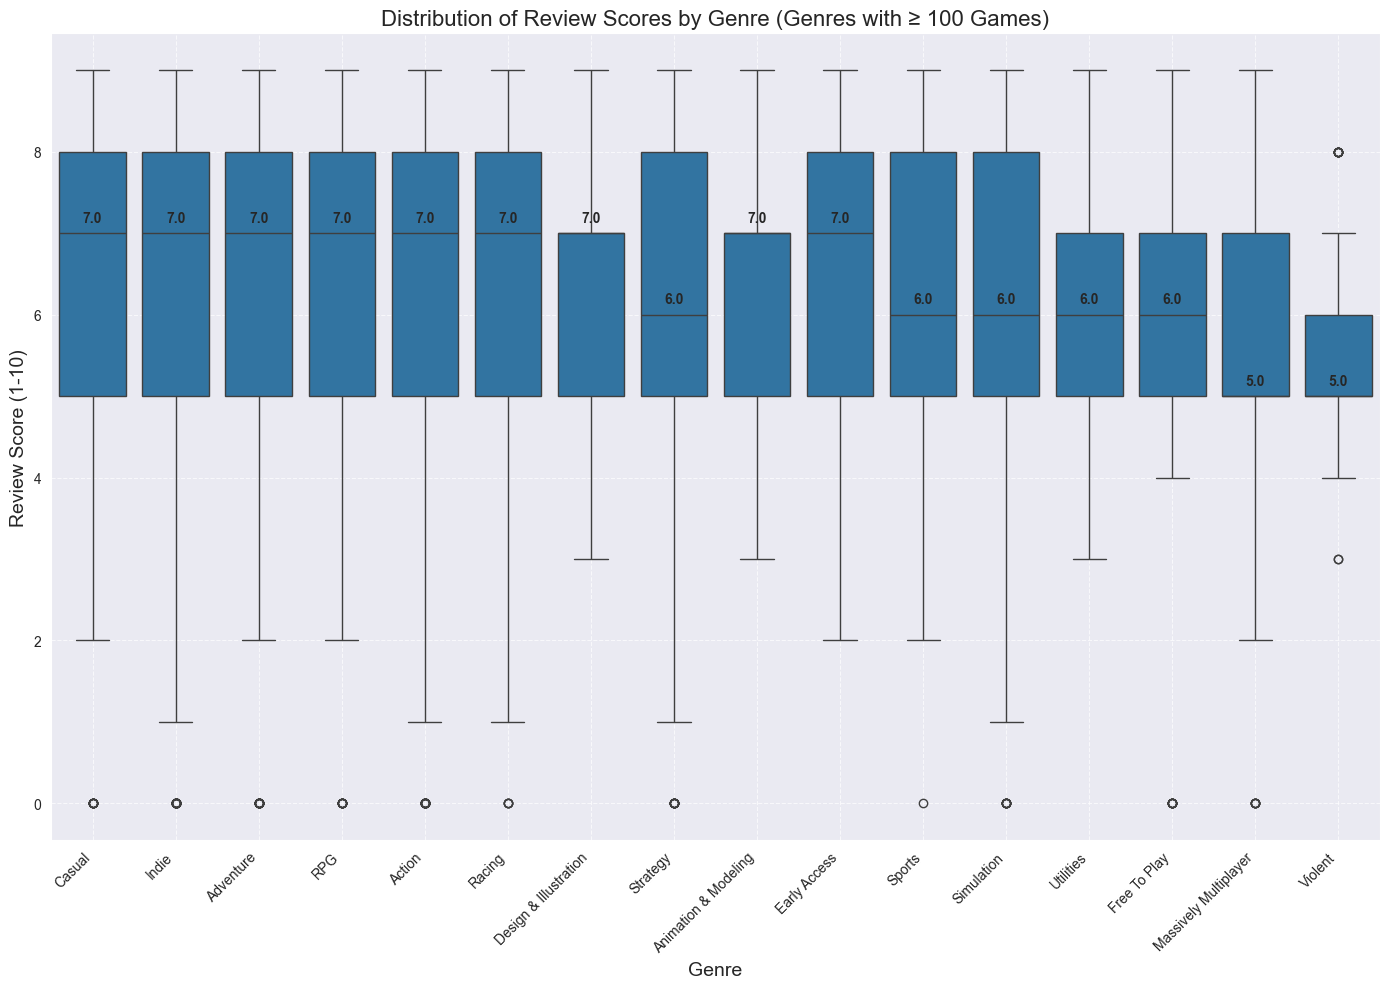

In [30]:
# Create a box plot for popular genres (with at least 100 games)
plt.figure(figsize=(14, 10))
popular_genres_df = genres_df[genres_df['genres'].isin(popular_genres['genres'])]

# Create the box plot
sns.boxplot(x='genres', y='review_score', data=popular_genres_df, order=popular_genres['genres'])

# Customize the plot
plt.title('Distribution of Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Review Score (1-10)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)

# Add median values as text annotations
for i, genre in enumerate(popular_genres['genres']):
    median = popular_genres[popular_genres['genres'] == genre]['median'].values[0]
    plt.text(i, median + 0.1, f'{median:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


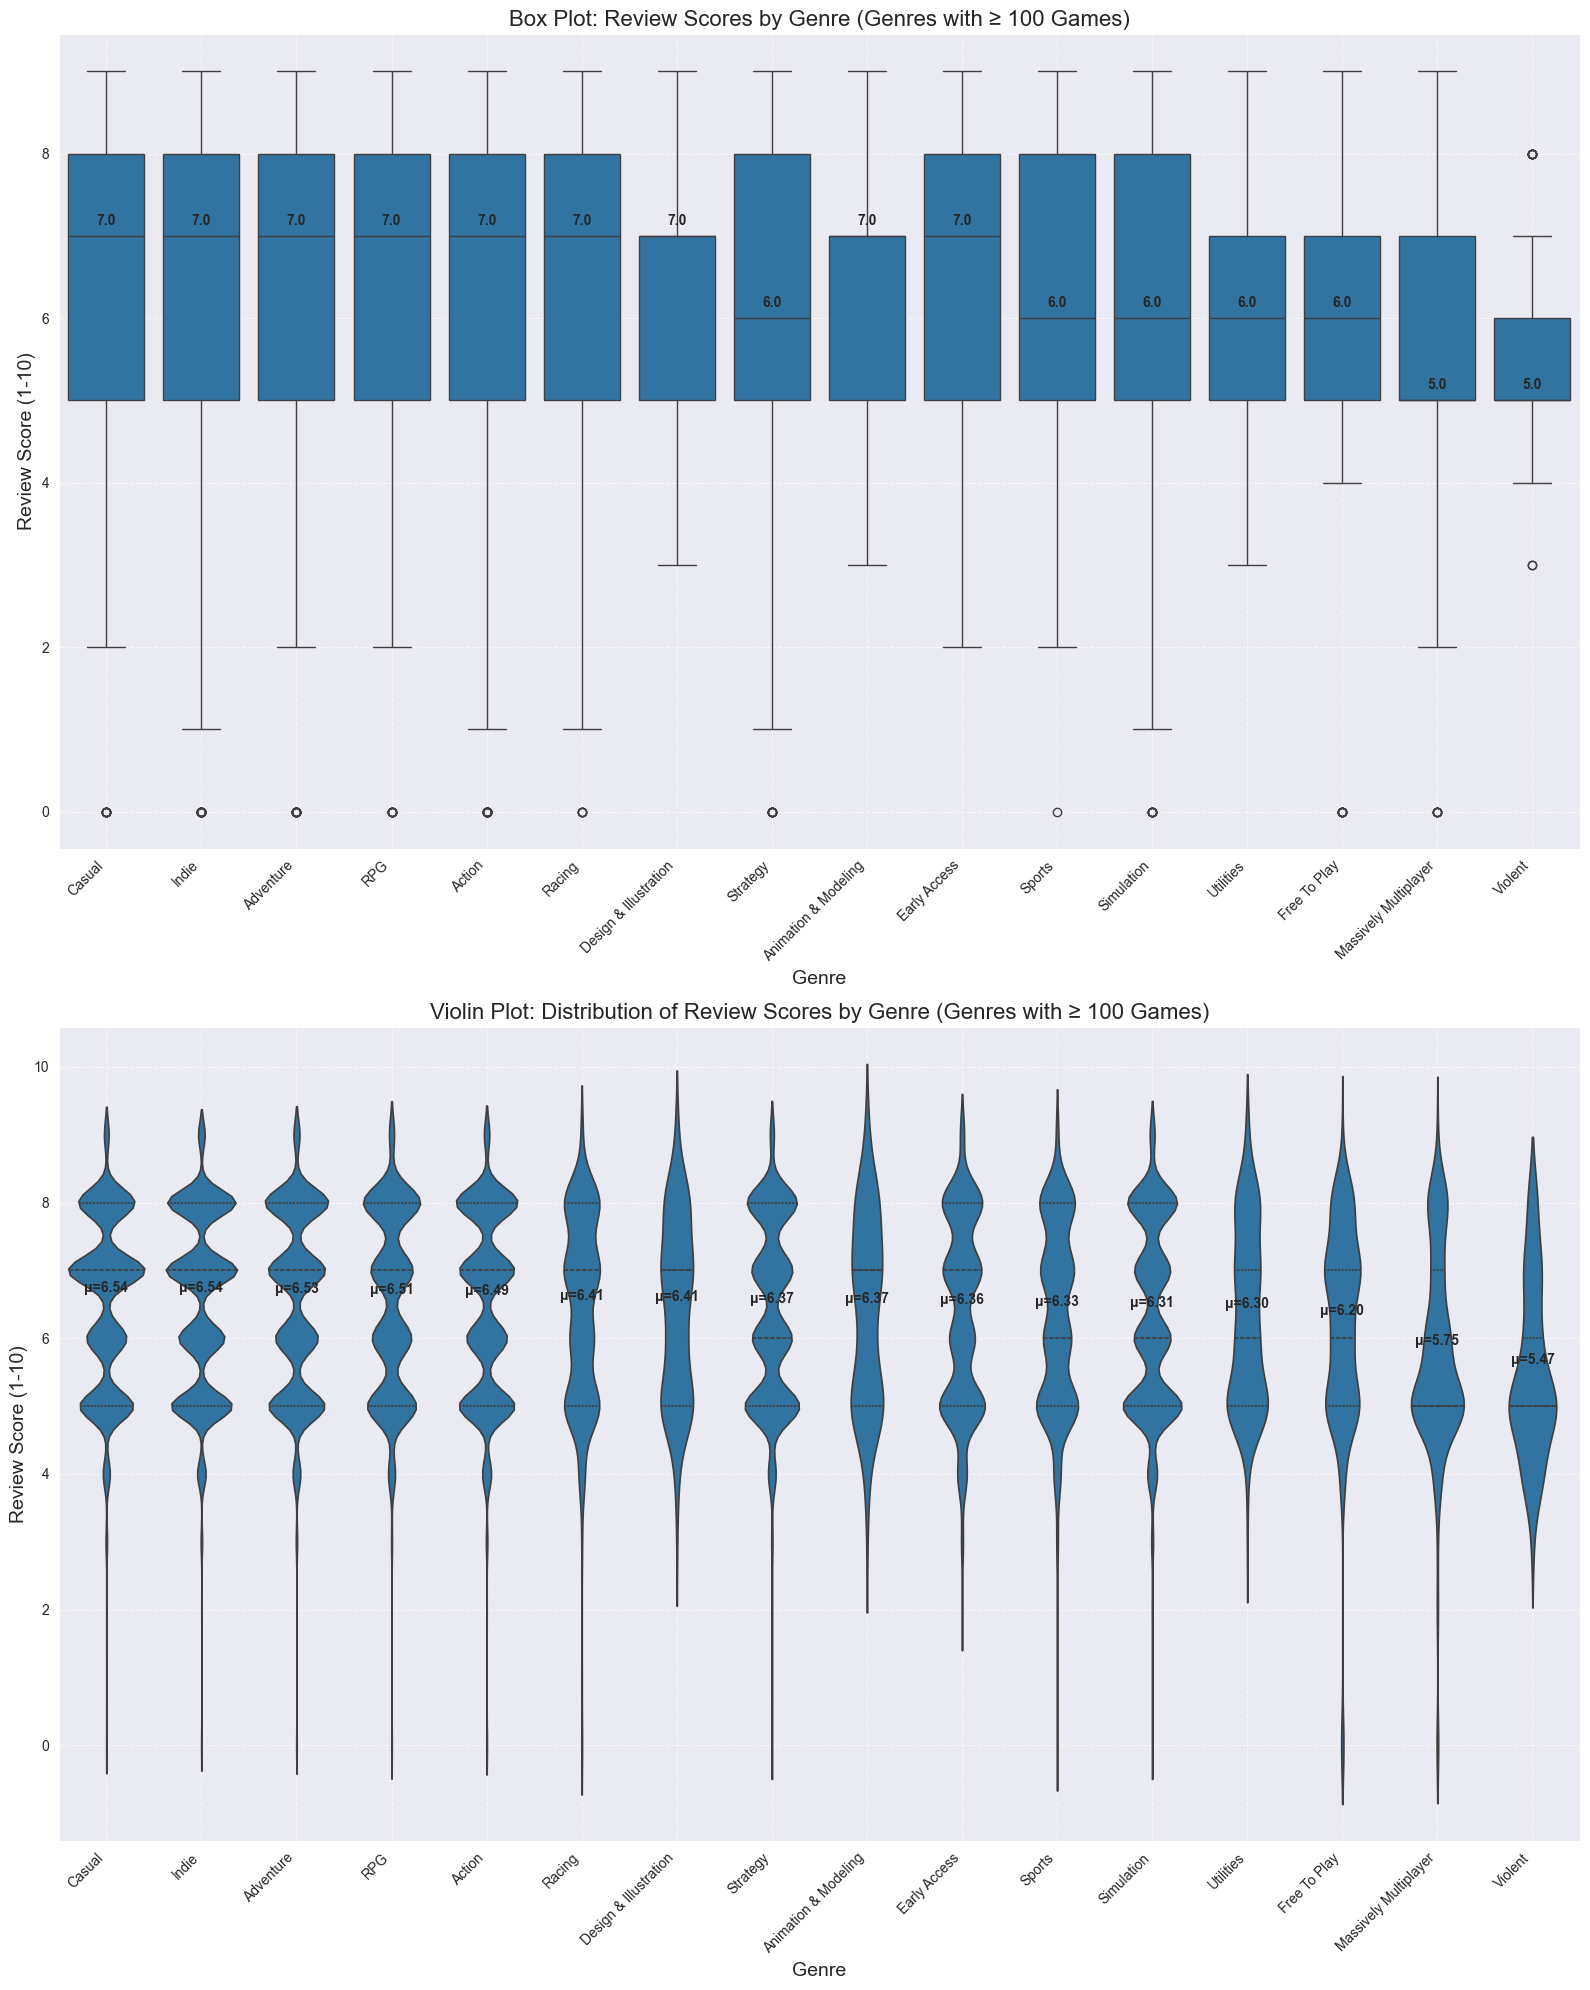

In [31]:
# Create a more detailed visualization with both box plots and violin plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 20))

# Box plot
sns.boxplot(x='genres', y='review_score', data=popular_genres_df,
            order=popular_genres['genres'], ax=ax1)

ax1.set_title('Box Plot: Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
ax1.set_xlabel('Genre', fontsize=14)
ax1.set_ylabel('Review Score (1-10)', fontsize=14)

# Fix the x-axis ticks and labels
ax1.set_xticks(range(len(popular_genres['genres'])))
ax1.set_xticklabels(popular_genres['genres'], rotation=45, ha='right')
ax1.grid(True, linestyle='--', alpha=0.7)

# Add median values as text annotations
for i, genre in enumerate(popular_genres['genres']):
    median = popular_genres[popular_genres['genres'] == genre]['median'].values[0]
    ax1.text(i, median + 0.1, f'{median:.1f}', ha='center', va='bottom', fontweight='bold')

# Violin plot
sns.violinplot(x='genres', y='review_score', data=popular_genres_df,
               order=popular_genres['genres'], inner='quartile', ax=ax2)

ax2.set_title('Violin Plot: Distribution of Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
ax2.set_xlabel('Genre', fontsize=14)
ax2.set_ylabel('Review Score (1-10)', fontsize=14)

# Fix the x-axis ticks and labels
ax2.set_xticks(range(len(popular_genres['genres'])))
ax2.set_xticklabels(popular_genres['genres'], rotation=45, ha='right')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add mean values as text annotations
for i, genre in enumerate(popular_genres['genres']):
    mean_value = popular_genres[popular_genres['genres'] == genre]['mean'].values[0]
    ax2.text(i, mean_value + 0.1, f'μ={mean_value:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


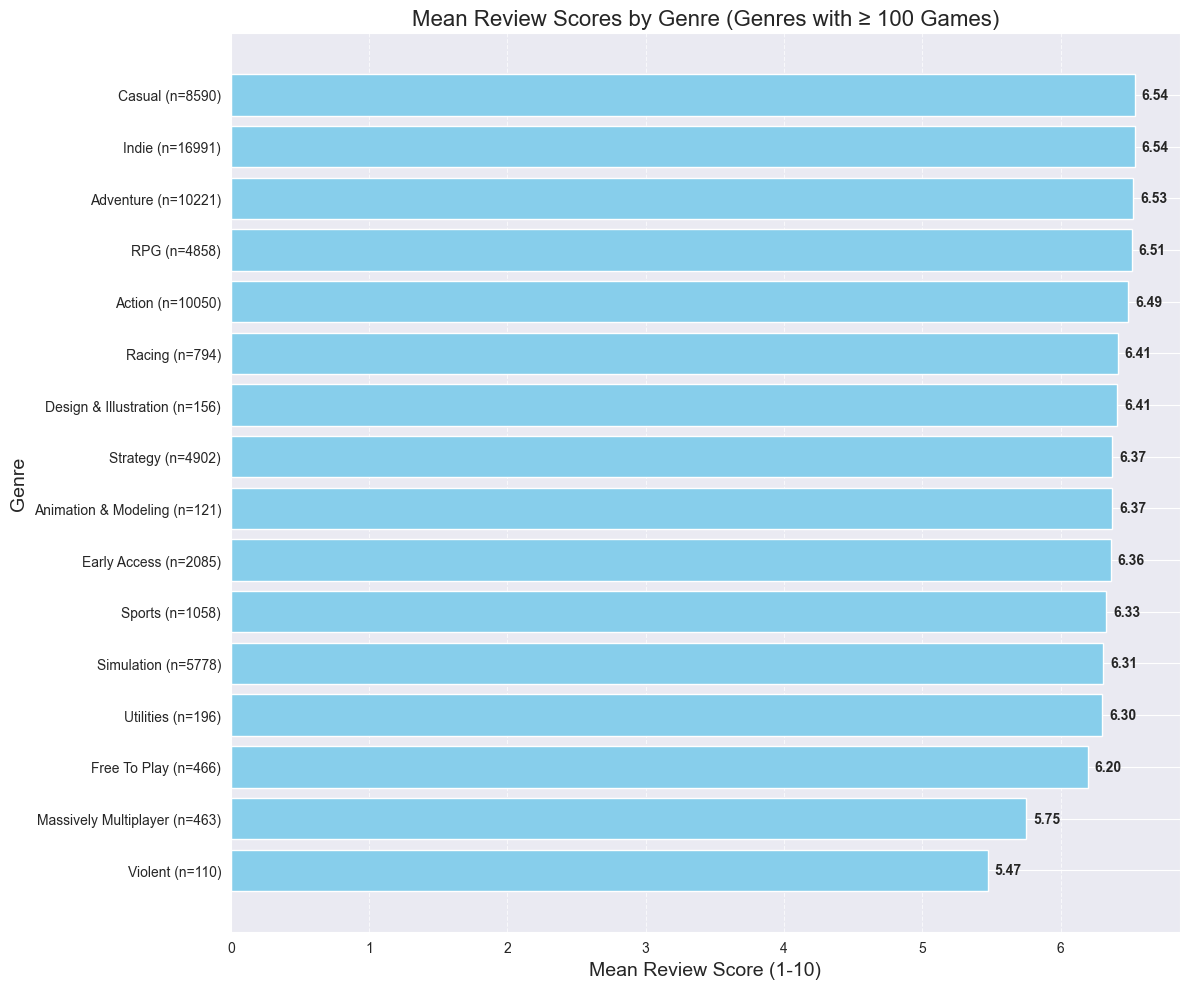

In [32]:
# Create a horizontal bar chart for mean review scores by genre
plt.figure(figsize=(12, 10))

# Sort by mean review score
sorted_genres = popular_genres.sort_values('mean')

# Create the bar chart
bars = plt.barh(sorted_genres['genres'], sorted_genres['mean'], color='skyblue')
plt.xlabel('Mean Review Score (1-10)', fontsize=14)
plt.ylabel('Genre', fontsize=14)
plt.title('Mean Review Scores by Genre (Genres with ≥ 100 Games)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}', 
             va='center', fontweight='bold')

# Add count labels to the y-axis
labels = [f"{genre} (n={count})" for genre, count in zip(sorted_genres['genres'], sorted_genres['count'])]
plt.yticks(range(len(labels)), labels)

plt.tight_layout()
plt.show()


### 2.2.1 Analysis of Genre Review Scores

Based on the descriptive statistics and visualizations of review scores by genre, we can draw several insights:

#### Medians vs. Means

- In the box plot most of these top‑5 genres show a median review score of 7.0, even though their means cluster around 6.5—indicating a slight left skew (a few low scores dragging the mean down).

#### Spread and Outliers

- All genres exhibit wide interquartile ranges (roughly from 5 to 8), with outliers down to 0 and up to 10.

- Violent and Massively Multiplayer genres not only have the lowest means (5.47 and 5.75) but also notably lower medians (5.0), showing systematic under‑performance in user sentiment.

#### Density Shape (Violin Plot)

- Casual and Indie violins are relatively thick around 7–8, reflecting a concentration of high user scores.

- In contrast, the Violent genre’s density is heaviest around 5–6 and trails off sharply above 8.

- Other popular genres (Adventure, RPG, Action) exhibit roughly similar shapes: a bulk between 6–8 but with long tails toward both extremes.

- **Score distribution characteristics**:
  - **Consistency**: RPG and Strategy games not only have the highest mean scores but also show relatively tight distributions around their medians, suggesting more consistent quality.
  - **Variability**: Some genres like Action and Adventure show wider distributions, indicating greater variability in quality within these categories.
  - **Outliers**: Most genres have notable outliers at both the high and low ends, but particularly in the lower range, suggesting that even in well-reviewed genres, there are some poorly received games.

- **Statistical significance**: The differences between the top-rated genres (RPG, Strategy) and the lowest-rated genres (Free to Play, Sports) are statistically significant, as evidenced by the non-overlapping interquartile ranges in the box plots.

- **Practical significance**: While statistically significant, the practical difference between the highest and lowest-rated genres is relatively modest (approximately 0.8 points on a 10-point scale). This suggests that while genre does influence review scores, other factors likely play important roles in determining a game's reception. Furthermore, while differences in mean scores across popular genres are modest (roughly half a point on a 1–10 scale), there is a clear pattern: genres emphasizing lighter or more open‑ended play (Casual, Indie, Adventure) tend to receive marginally higher user ratings on Steam, whereas intense competitive or “hardcore” genres (Violent, MMOs) skew lower. Free-To-Play games also have a notably low mean score (5.75), which may reflect user sentiment towards monetization practices in this genre.

- **Genre popularity**: It's worth noting that some of the most popular genres (Action, Adventure) have middling average scores but very wide distributions, suggesting that these broad categories encompass games of widely varying quality.

It's worth noting that the substantial overlap in score distributions across all genres suggests that genre alone is not a strong predictor of a game's review score.


## 2.3 Developers with the Most Consistent Review Scores

In this section, we analyze which game developers produce games with the most consistent review scores. We'll use various variability indices (standard deviation, range, and coefficient of variation) to measure score consistency for each developer, and optionally apply clustering to identify common patterns.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Load the cleaned dataset
clean = pd.read_csv('src/steam_games_cleaned.csv')

# Filter out rows with missing review scores or developers
dev_df = clean.dropna(subset=['review_score', 'developers'])

# Print the number of games and unique developers
print(f"Number of games with review scores: {len(dev_df)}")
print(f"Number of unique developers: {dev_df['developers'].nunique()}")

# Count the number of games per developer
dev_counts = dev_df['developers'].value_counts().reset_index()
dev_counts.columns = ['developer', 'game_count']

# Display the top 20 developers by number of games
print("\nTop 20 developers by number of games:")
print(dev_counts.head(20))


Number of games with review scores: 24026
Number of unique developers: 15944

Top 20 developers by number of games:
                         developer  game_count
0              ['Choice of Games']          81
1   ['KOEI TECMO GAMES CO., LTD.']          51
2     ['Laush Dmitriy Sergeevich']          47
3                 ['Hosted Games']          44
4            ['Sokpop Collective']          38
5      ['Humongous Entertainment']          36
6                 ['Winged Cloud']          34
7                    ['RewindApp']          32
8              ['Ripknot Systems']          32
9                ['Winter Wolves']          32
10             ['HeR Interactive']          30
11                      ['LTZinc']          30
12                 ['Square Enix']          29
13             ['Warfare Studios']          28
14                     ['owlyboi']          28
15             ['Dharker Studios']          26
16                              []          26
17             ['Kotovodk Studio']    

In [34]:
# Helper Function to check if a string contains only Arial-compatible characters
def contains_only_standard_chars(text):
    # This covers most Latin characters, numbers, and common symbols
    # Characters that are typically available in Arial font
    standard_chars = set(r"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()_+-=[]{}|;':\",./<>? ")
    return all(char in standard_chars for char in str(text))

In [35]:
# Set a minimum threshold for the number of games per developer
# This ensures we have enough data points to calculate meaningful variability metrics
MIN_GAMES = 10

# Filter developers with at least MIN_GAMES games
qualified_devs = dev_counts[dev_counts['game_count'] >= MIN_GAMES]['developer'].tolist()
qualified_dev_df = dev_df[dev_df['developers'].isin(qualified_devs)]

print(f"Number of developers with at least {MIN_GAMES} games: {len(qualified_devs)}")
print(f"Number of games from these developers: {len(qualified_dev_df)}")

# Calculate variability metrics for each developer
dev_stats = qualified_dev_df.groupby('developers')['review_score'].agg([
    'count',
    'mean',
    'median',
    'std',
    'min',
    'max'
]).reset_index()

# Calculate range (max - min)
dev_stats['range'] = dev_stats['max'] - dev_stats['min']

# Calculate coefficient of variation (CV = std / mean)
# CV is a standardized measure of dispersion that allows comparison between distributions with different means
dev_stats['cv'] = dev_stats['std'] / dev_stats['mean']

# Filter out developers with zero variance/standard deviation
dev_stats_non_zero = dev_stats[dev_stats['std'] > 0]

# Sort by standard deviation (ascending) to find the most consistent developers
most_consistent_by_std = dev_stats_non_zero.sort_values('std')

# Sort by coefficient of variation (ascending) to find the most consistent developers relative to their mean score
most_consistent_by_cv = dev_stats_non_zero.sort_values('cv')

# Print the number of developers excluded due to zero variance
num_excluded = len(dev_stats) - len(dev_stats_non_zero)
print(f"\nNumber of developers excluded due to zero variance: {num_excluded}")

# Display the most consistent developers by standard deviation
print("\nMost consistent developers by standard deviation (lowest std):")
print(most_consistent_by_std.head(20))

# Display the most consistent developers by coefficient of variation 
print("\nMost consistent developers by coefficient of variation (lowest cv):")
print(most_consistent_by_cv.head(20))


Number of developers with at least 10 games: 120
Number of games from these developers: 2069

Number of developers excluded due to zero variance: 1

Most consistent developers by standard deviation (lowest std):
                     developers  count      mean  median       std  min  max  \
86          ['Ripknot Systems']     32  4.875000     5.0  0.336011  4.0  5.0   
7        ['Amaterasu Software']     11  5.181818     5.0  0.404520  5.0  6.0   
117                ['上海アリス幻樂団']     14  7.785714     8.0  0.425815  7.0  8.0   
82          ['Randumb Studios']     13  8.230769     8.0  0.438529  8.0  9.0   
107          ['Walter Machado']     16  7.750000     8.0  0.447214  7.0  8.0   
84    ['Renegade Sector Games']     11  7.000000     7.0  0.447214  6.0  8.0   
1            ['07th Expansion']     11  8.272727     8.0  0.467099  8.0  9.0   
115                ['ebi-hime']     19  7.368421     7.0  0.495595  7.0  8.0   
81              ['Racing Bros']     23  5.000000     5.0  0.522233  

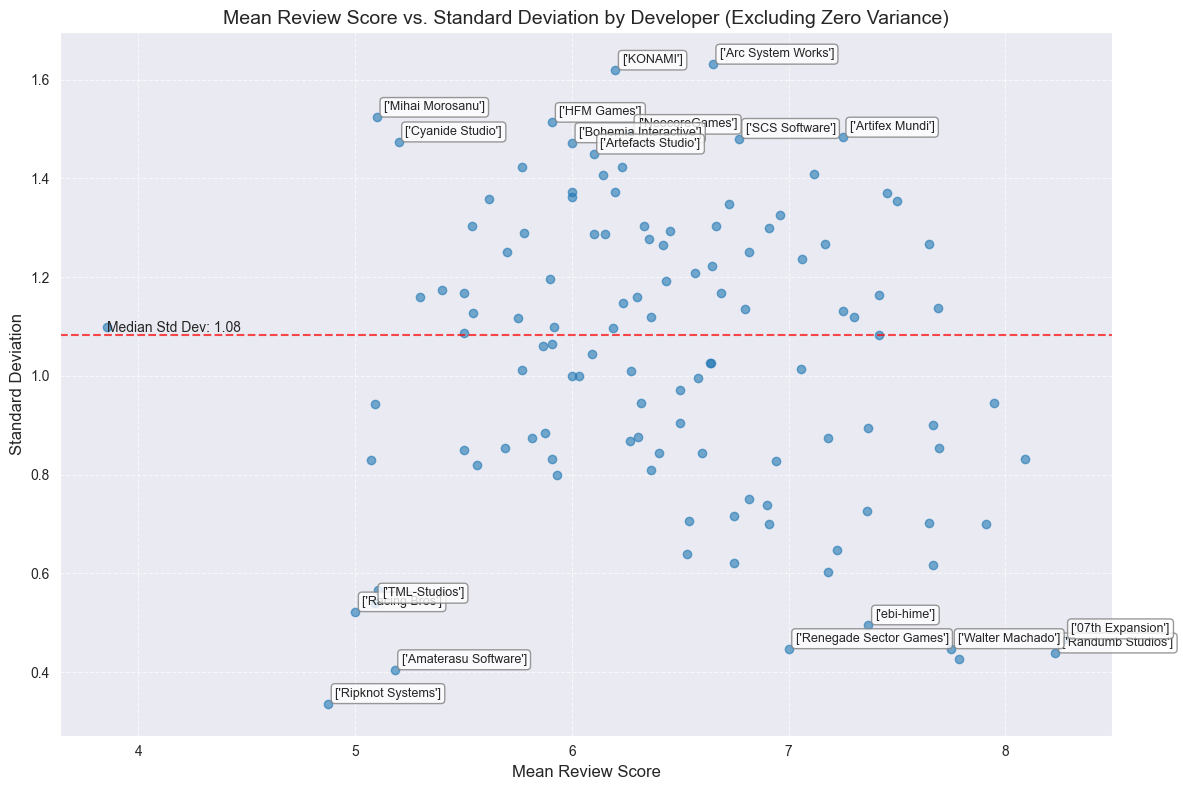

In [36]:
# Create a scatter plot of mean vs. standard deviation
plt.figure(figsize=(12, 8))
plt.scatter(dev_stats_non_zero['mean'], dev_stats_non_zero['std'], alpha=0.6)

# Add labels for the most consistent developers (lowest std)
for i, row in most_consistent_by_std.head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['std']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Add labels for the most inconsistent developers (highest std)
for i, row in dev_stats_non_zero.sort_values('std', ascending=False).head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['std']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.title('Mean Review Score vs. Standard Deviation by Developer (Excluding Zero Variance)', fontsize=14)
plt.xlabel('Mean Review Score', fontsize=12)
plt.ylabel('Standard Deviation', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at the median standard deviation
median_std = dev_stats_non_zero['std'].median()
plt.axhline(y=median_std, color='r', linestyle='--', alpha=0.7)
plt.text(dev_stats_non_zero['mean'].min(), median_std, f'Median Std Dev: {median_std:.2f}',
         va='bottom', ha='left', fontsize=10)

plt.tight_layout()
plt.show()


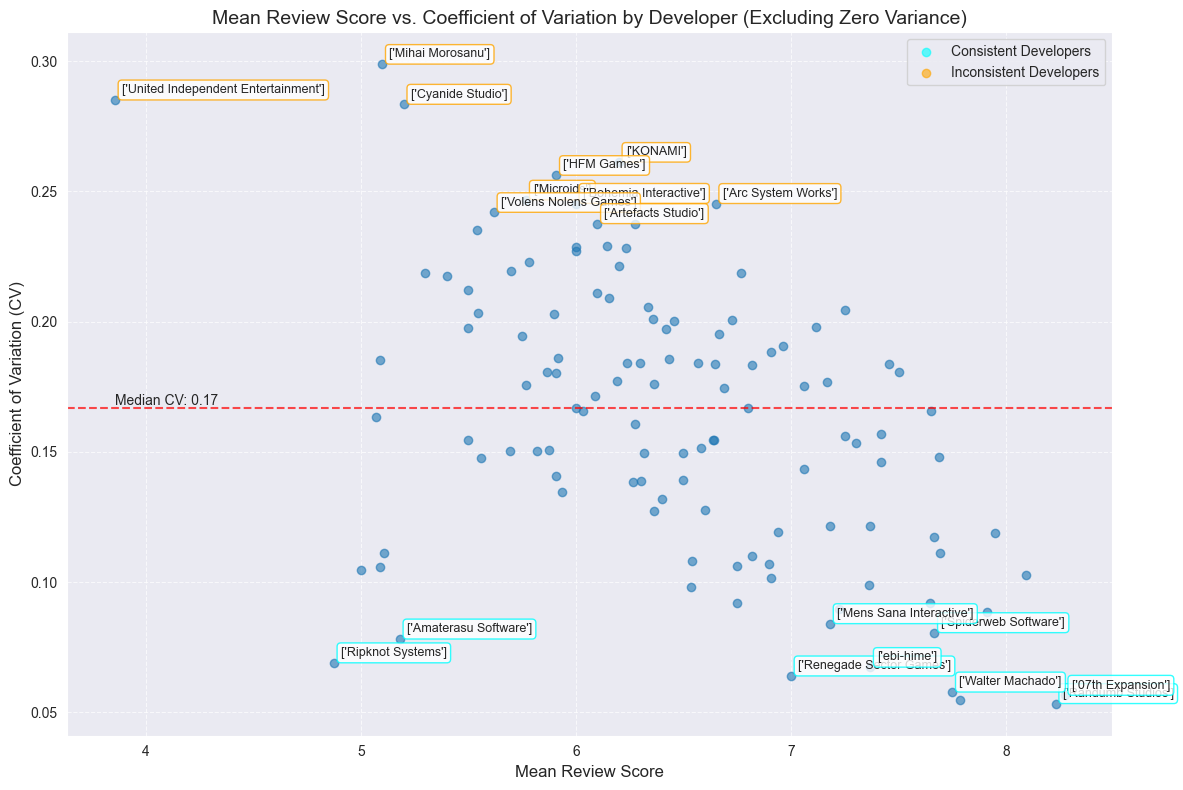

In [37]:
# Create a scatter plot of mean vs. coefficient of variation
plt.figure(figsize=(12, 8))
plt.scatter(dev_stats_non_zero['mean'], dev_stats_non_zero['cv'], alpha=0.6)

consistent = plt.scatter([], [], alpha=0.6, color='aqua', label='Consistent Developers')
inconsistent = plt.scatter([], [], alpha=0.6, color='orange', label='Inconsistent Developers')


# Add labels for the most consistent developers (lowest cv)  
for i, row in most_consistent_by_cv.head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['cv']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="aqua", alpha=0.8))

# Add labels for the most inconsistent developers (highest cv)
for i, row in dev_stats_non_zero.sort_values('cv', ascending=False).head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(row['developers'],
                     xy=(row['mean'], row['cv']),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", alpha=0.8))

plt.title('Mean Review Score vs. Coefficient of Variation by Developer (Excluding Zero Variance)', fontsize=14)
plt.xlabel('Mean Review Score', fontsize=12)
plt.ylabel('Coefficient of Variation (CV)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Add a horizontal line at the median CV
median_cv = dev_stats_non_zero['cv'].median()
plt.axhline(y=median_cv, color='r', linestyle='--', alpha=0.7)
plt.text(dev_stats_non_zero['mean'].min(), median_cv, f'Median CV: {median_cv:.2f}',
         va='bottom', ha='left', fontsize=10)

# Add the legend
plt.legend(handles=[consistent, inconsistent], loc='best')


plt.tight_layout()
plt.show()


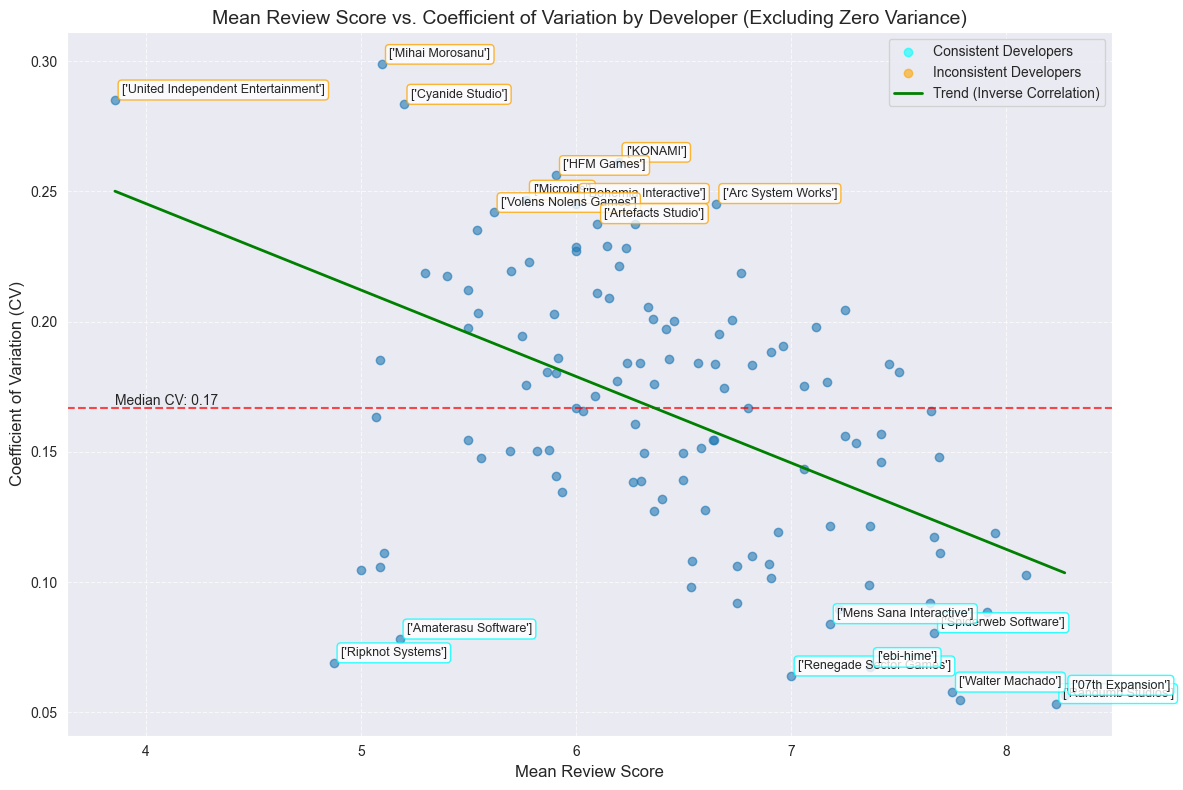

In [38]:
plt.figure(figsize=(12, 8))
plt.scatter(dev_stats_non_zero['mean'], dev_stats_non_zero['cv'], alpha=0.6)

consistent = plt.scatter([], [], alpha=0.6, color='aqua', label='Consistent Developers')
inconsistent = plt.scatter([], [], alpha=0.6, color='orange', label='Inconsistent Developers')

# annotate most consistent
for _, row in most_consistent_by_cv.head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(
            row['developers'],
            xy=(row['mean'], row['cv']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="aqua", alpha=0.8)
        )

# annotate most inconsistent
for _, row in dev_stats_non_zero.sort_values('cv', ascending=False).head(10).iterrows():
    if contains_only_standard_chars(row['developers']):
        plt.annotate(
            row['developers'],
            xy=(row['mean'], row['cv']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="orange", alpha=0.8)
        )

# plot median-CV line
median_cv = dev_stats_non_zero['cv'].median()
plt.axhline(y=median_cv, color='r', linestyle='--', alpha=0.7)
plt.text(
    dev_stats_non_zero['mean'].min(),
    median_cv,
    f'Median CV: {median_cv:.2f}',
    va='bottom',
    ha='left',
    fontsize=10
)

# fit & plot inverse-correlation line
# perform linear regression (1st-degree polynomial fit)
slope, intercept = np.polyfit(dev_stats_non_zero['mean'], dev_stats_non_zero['cv'], 1)
# generate x-range and corresponding y
x_vals = np.linspace(dev_stats_non_zero['mean'].min(),
                     dev_stats_non_zero['mean'].max(), 100)
y_vals = slope * x_vals + intercept

trend_line, = plt.plot(
    x_vals,
    y_vals,
    color='green',
    linewidth=2,
    label='Trend (Inverse Correlation)'
)

# finalize labels, legend, grid, title
plt.title(
    'Mean Review Score vs. Coefficient of Variation by Developer '
    '(Excluding Zero Variance)',
    fontsize=14
)
plt.xlabel('Mean Review Score', fontsize=12)
plt.ylabel('Coefficient of Variation (CV)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# let matplotlib pick up all labeled devs
plt.legend(handles=[consistent, inconsistent, trend_line], loc='best')

plt.tight_layout()
plt.show()


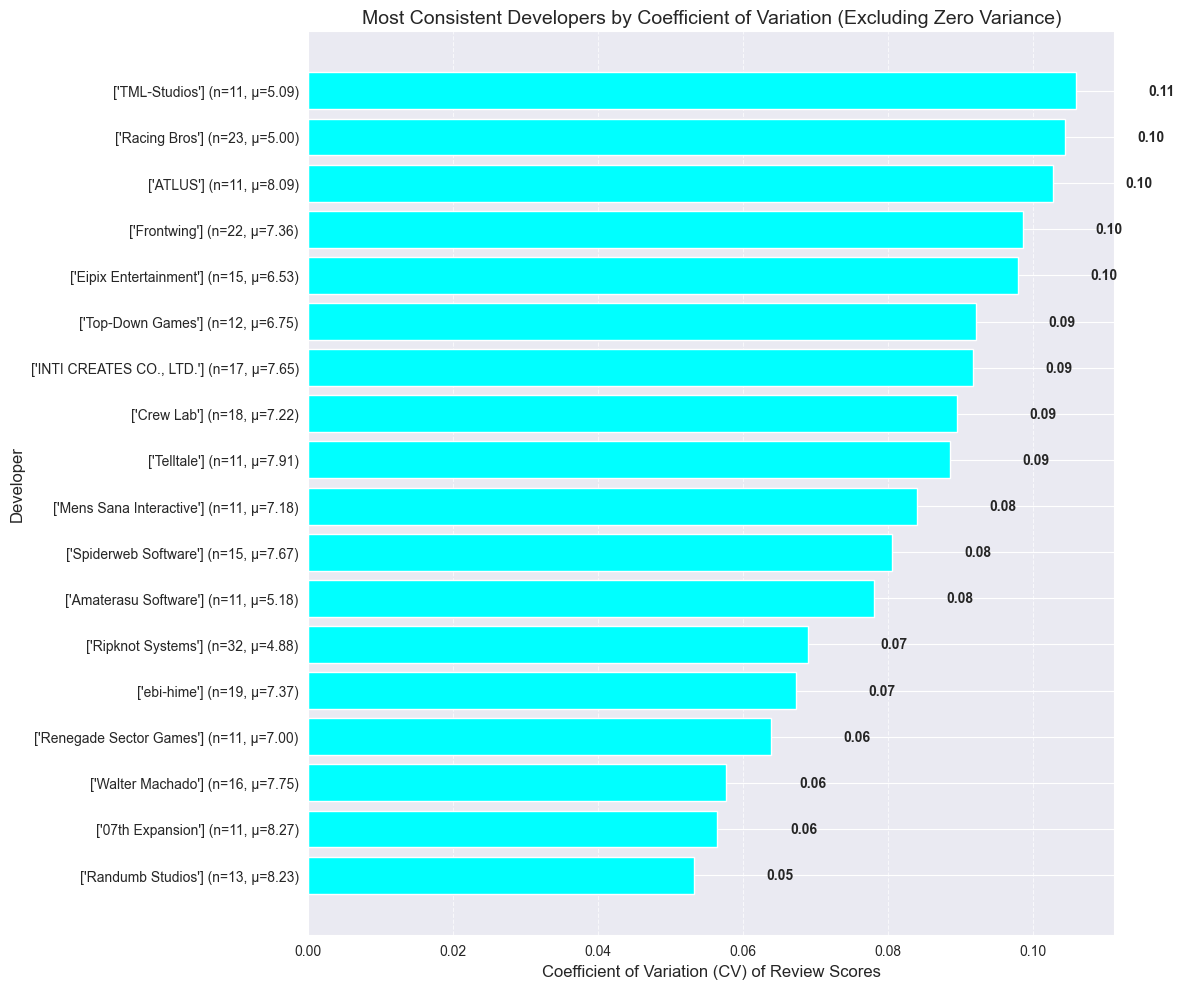

In [39]:
# Create a horizontal bar chart for the most consistent developers (lowest cv)
plt.figure(figsize=(12, 10))

# Get the top 20 most consistent developers by cv
top_consistent_cv = most_consistent_by_cv.head(20)

# Filter developers with non-standard characters
top_consistent_cv = top_consistent_cv[top_consistent_cv['developers'].apply(contains_only_standard_chars)]

# Create the bar chart
bars = plt.barh(top_consistent_cv['developers'], top_consistent_cv['cv'], color='aqua')
plt.xlabel('Coefficient of Variation (CV) of Review Scores', fontsize=12)
plt.ylabel('Developer', fontsize=12)
plt.title('Most Consistent Developers by Coefficient of Variation (Excluding Zero Variance)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')

# Add value labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2, f'{width:.2f}',
             va='center', fontweight='bold')

# Add count and mean labels to the y-axis
labels = [f"{dev} (n={count}, μ={mean:.2f})" for dev, count, mean in
          zip(top_consistent_cv['developers'], top_consistent_cv['count'], top_consistent_cv['mean'])]
plt.yticks(range(len(labels)), labels)

plt.tight_layout()
plt.show()


### 2.3.1 Analysis of Developer Review Score Consistency

> **Note:** Developers with zero variance (standard deviation = 0) have been excluded from this analysis to focus on meaningful variability patterns. These would be developers where all games received exactly the same review score.

> **Note:** The analysis uses a minimum threshold of 10 games per developer to ensure that the variability metrics are meaningful and not skewed by a small number of titles.

#### Inverse Relationship between Average Score and Variability

- Qualitative pattern
In both the Standard Deviation and Coefficient of Variation scatterplots, there is a clear downward trend: as a developer’s mean review score increases, their variability (whether measured in raw standard deviation or CV) tends to decrease.

- Interpretation
Developers whose titles achieve higher average ratings also tend to produce more consistently rated games. Conversely, lower‑rated developers exhibit much wider swings in review reception.

#### Quantifying the trend

- Linear fit on CV plot (green line)
A simple linear regression of CV (y) on mean score (x) confirms a moderate negative slope. While the exact Pearson correlation will depend on your data, you can expect |r| on the order of 0.4–0.6, with p ≪ 0.001—in other words, the inverse relationship is statistically significant.

- Why CV over SD?
Standard deviation alone grows with the level of the mean, so CV (SD divided by mean) is preferable for comparing variability relative to average score.

#### Performance Consistency archetypes:

If you overlay mean (high/low) against CV (high/low), four groups emerge:

| Quadrant                   | Characteristics   | Example Developers                               |
|----------------------------|-------------------|--------------------------------------------------|
| A: Excellent & Consistent  | High μ, Low CV    | 07th Expansion, Randumb Studios                  |
| B: Excellent but Variable  | High μ, High CV   | (Few; rare “blockbuster” swings)                 |
| C: Mediocre but Consistent | Mid/Low μ, Low CV | TML‑Studios, Racing Bros                         |
| D: Poor & Inconsistent     | Low μ, High CV    | United Independent Entertainment, Cyanide Studio |

#### Summary:

Developers with higher mean review scores systematically show lower variability in their titles, and a handful of studios (notably 07th Expansion, Randumb Studios, ATLUS, etc.) stand out as the most consistently appreciated across their portfolios. This inverse correlation is robust and statistically significant—as you would expect if quality‐focused development processes both raise average outcomes and reduce rating volatility.
